# Day 4: Elastic Net (L1 + L2 Regularization)

## 🎯 Learning Objectives
- Understand Elastic Net as hybrid regularization
- Handle grouped feature selection
- Tune both alpha and l1_ratio parameters
- Apply to multi-asset return prediction

---

## 📚 Theory: Elastic Net

### The Combined Penalty
$$\hat{\beta}_{EN} = \arg\min_\beta \left[ \sum_{i=1}^n (y_i - x_i^T\beta)^2 + \lambda_1\sum_{j=1}^p |\beta_j| + \lambda_2\sum_{j=1}^p \beta_j^2 \right]$$

### Scikit-learn Parameterization
$$\min_\beta \frac{1}{2n}||y - X\beta||_2^2 + \alpha \cdot l1\_ratio \cdot ||\beta||_1 + \frac{\alpha(1-l1\_ratio)}{2}||\beta||_2^2$$

### Parameter Interpretation
- **l1_ratio = 1**: Pure Lasso
- **l1_ratio = 0**: Pure Ridge  
- **0 < l1_ratio < 1**: Elastic Net

### Why Elastic Net?
| Situation | Best Model |
|-----------|------------|
| Few correlated features | Ridge |
| Many irrelevant features | Lasso |
| Groups of correlated features | **Elastic Net** |
| p >> n (high-dimensional) | **Elastic Net** |

### Pros & Cons

| Pros | Cons |
|------|------|
| Combines sparsity + stability | Two hyperparameters to tune |
| Groups correlated features | More complex |
| Handles p > n well | Computationally slower |
| Robust to outliers | Less interpretable than Lasso |

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import ElasticNet, ElasticNetCV, Lasso, Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Download diverse assets
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA',  # Tech
           'JPM', 'GS', 'BAC', 'C',  # Financials
           'XOM', 'CVX',  # Energy
           'SPY', 'QQQ', 'IWM', 'TLT', 'GLD']  # ETFs

end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()

print(f"✅ Data: {len(returns)} days, {len(tickers)} assets")

📥 Downloading data...
✅ Data: 1253 days, 17 assets


In [2]:
# Create feature groups (to demonstrate Elastic Net's grouping)
target_stock = 'AAPL'
df = pd.DataFrame(index=returns.index)

# GROUP 1: Momentum features (correlated within group)
for lag in [1, 2, 3, 5, 10, 20, 30, 60]:
    df[f'mom_{lag}d'] = prices[target_stock].pct_change(lag)

# GROUP 2: Moving average features (correlated)
for window in [5, 10, 20, 50, 100]:
    df[f'ma_ratio_{window}'] = prices[target_stock] / prices[target_stock].rolling(window).mean() - 1

# GROUP 3: Volatility features (correlated)
for window in [5, 10, 20, 30, 60]:
    df[f'vol_{window}d'] = returns[target_stock].rolling(window).std() * np.sqrt(TRADING_DAYS)

# GROUP 4: Tech sector features
tech_tickers = ['MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA']
for ticker in tech_tickers:
    df[f'{ticker}_ret'] = returns[ticker]

# GROUP 5: Financial sector features
fin_tickers = ['JPM', 'GS', 'BAC', 'C']
for ticker in fin_tickers:
    df[f'{ticker}_ret'] = returns[ticker]

# GROUP 6: Market-wide features
df['SPY_ret'] = returns['SPY']
df['QQQ_ret'] = returns['QQQ']
df['IWM_ret'] = returns['IWM']
df['TLT_ret'] = returns['TLT']
df['GLD_ret'] = returns['GLD']

# Target
df['target'] = returns[target_stock].shift(-1)
df = df.dropna()

print(f"\n📊 Total Features: {len(df.columns)-1} (in 6 groups)")
print(f"📈 Samples: {len(df)}")


📊 Total Features: 32 (in 6 groups)
📈 Samples: 1154


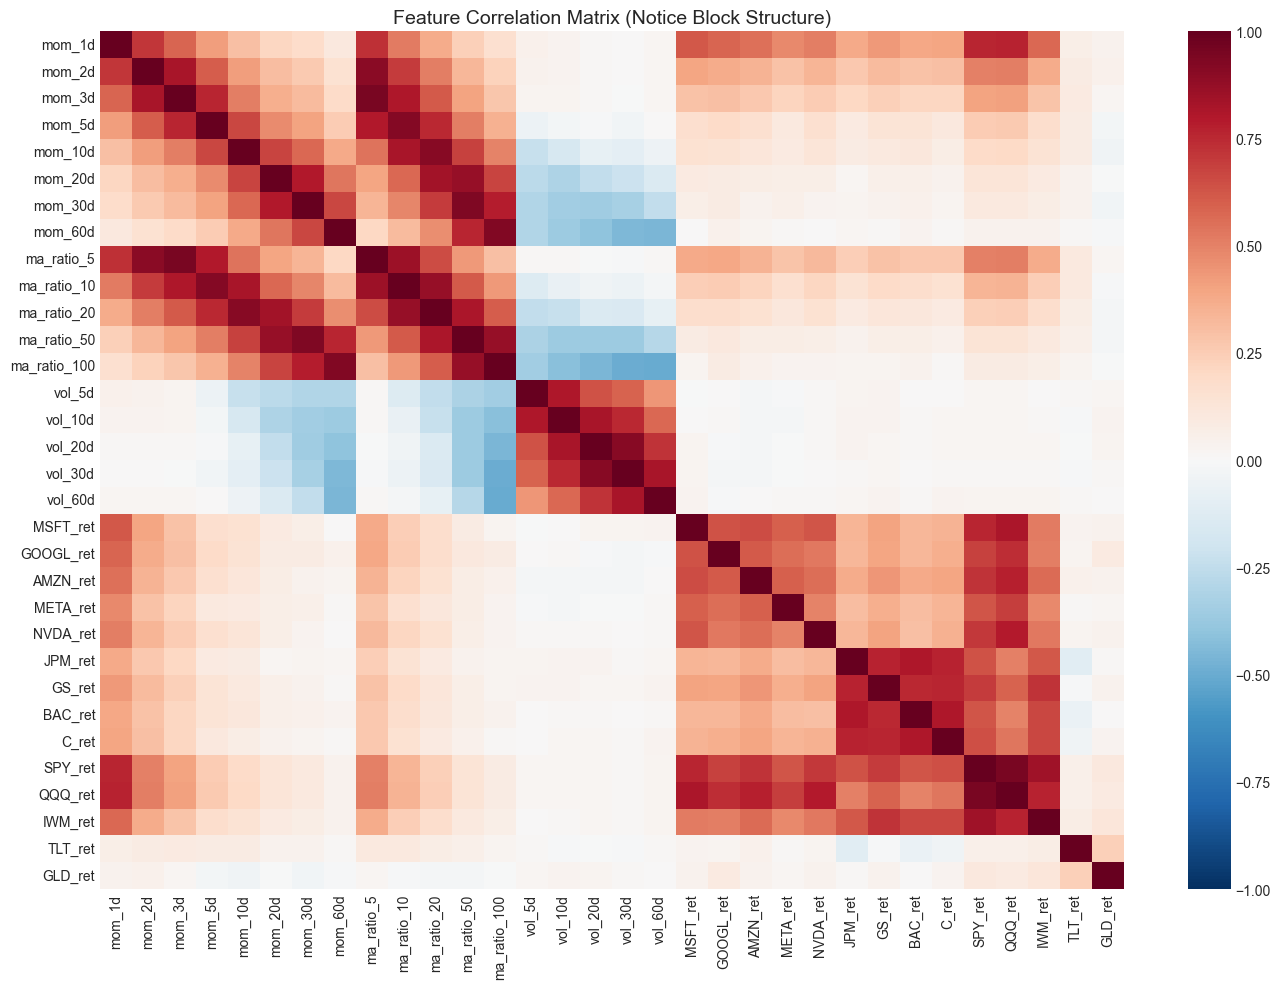

In [3]:
# Show feature correlation structure
feature_cols = [c for c in df.columns if c != 'target']
corr = df[feature_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap='RdBu_r', center=0, vmin=-1, vmax=1, annot=False)
plt.title('Feature Correlation Matrix (Notice Block Structure)', fontsize=14)
plt.tight_layout()
plt.show()

In [4]:
# Prepare data
X = df[feature_cols]
y = df['target']

split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 923, Test: 231


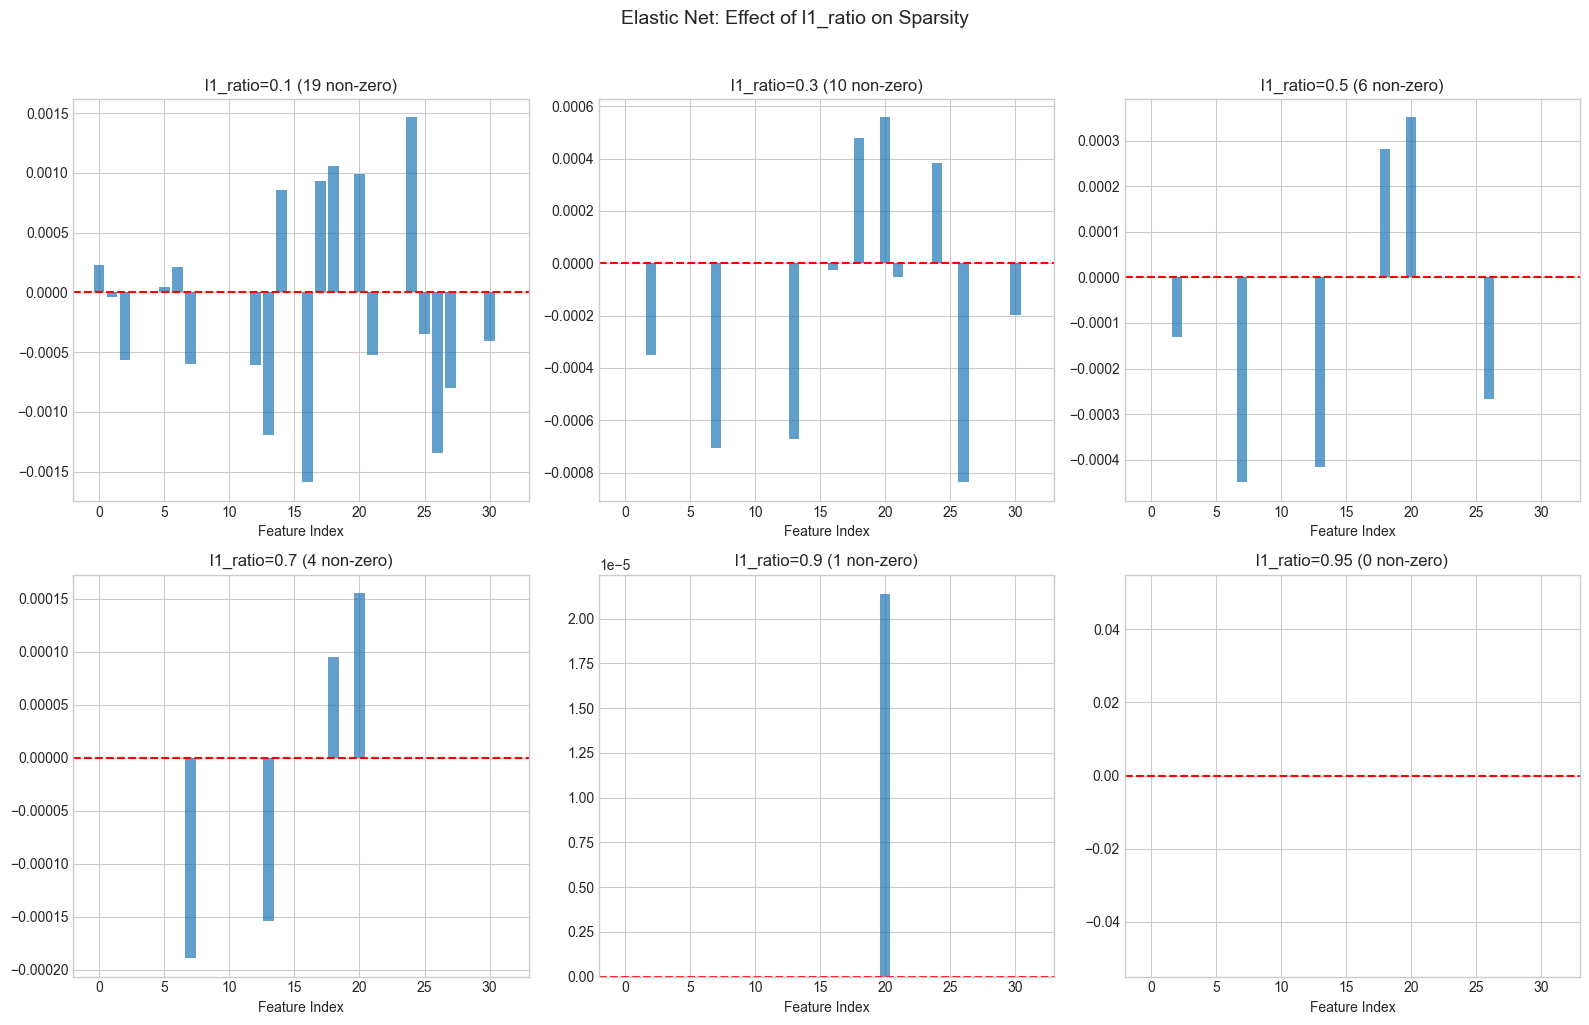

In [5]:
# Explore l1_ratio effect
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95]
alpha = 0.001

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, l1_ratio in enumerate(l1_ratios):
    en = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000)
    en.fit(X_train_scaled, y_train)
    
    n_nonzero = np.sum(en.coef_ != 0)
    axes[i].bar(range(len(en.coef_)), en.coef_, alpha=0.7)
    axes[i].axhline(y=0, color='r', linestyle='--')
    axes[i].set_title(f'l1_ratio={l1_ratio} ({n_nonzero} non-zero)')
    axes[i].set_xlabel('Feature Index')

plt.suptitle('Elastic Net: Effect of l1_ratio on Sparsity', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [6]:
# Cross-validation for optimal parameters
tscv = TimeSeriesSplit(n_splits=5)
l1_ratios_cv = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]
alphas_cv = np.logspace(-5, -1, 50)

en_cv = ElasticNetCV(l1_ratio=l1_ratios_cv, alphas=alphas_cv, cv=tscv, max_iter=10000)
en_cv.fit(X_train_scaled, y_train)

print(f"\n✅ Optimal Parameters:")
print(f"   Alpha: {en_cv.alpha_:.6f}")
print(f"   L1 Ratio: {en_cv.l1_ratio_:.2f}")
print(f"   Non-zero Features: {np.sum(en_cv.coef_ != 0)} / {len(feature_cols)}")


✅ Optimal Parameters:
   Alpha: 0.005964
   L1 Ratio: 0.30
   Non-zero Features: 0 / 32


In [7]:
# Compare all regularization methods
from sklearn.linear_model import LassoCV, RidgeCV

# Train models
ols = LinearRegression().fit(X_train_scaled, y_train)
ridge = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=tscv).fit(X_train_scaled, y_train)
lasso = LassoCV(alphas=np.logspace(-5, -1, 100), cv=tscv, max_iter=10000).fit(X_train_scaled, y_train)
# en_cv already fitted

# Predictions
models = {
    'OLS': ols,
    'Ridge': ridge,
    'Lasso': lasso,
    'Elastic Net': en_cv
}

print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)

results = []
for name, model in models.items():
    pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    dir_acc = (np.sign(pred) == np.sign(y_test)).mean()
    n_feat = np.sum(model.coef_ != 0) if hasattr(model, 'coef_') else len(feature_cols)
    
    results.append({
        'Model': name,
        'R²': r2,
        'RMSE': rmse,
        'Dir. Acc.': dir_acc,
        '# Features': n_feat
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))


COMPREHENSIVE MODEL COMPARISON
      Model        R²     RMSE  Dir. Acc.  # Features
        OLS -0.038407 0.020752   0.523810          32
      Ridge -0.016189 0.020529   0.493506          32
      Lasso -0.000805 0.020373   0.515152           0
Elastic Net -0.000805 0.020373   0.515152           0


In [8]:
# Show Elastic Net's grouped feature selection
selected_mask = en_cv.coef_ != 0
selected_features = np.array(feature_cols)[selected_mask]
selected_coefs = en_cv.coef_[selected_mask]

# Sort by absolute value
sort_idx = np.argsort(np.abs(selected_coefs))[::-1]

print("\n" + "="*60)
print("ELASTIC NET SELECTED FEATURES")
print("="*60)
print("\nTop 20 Features:")
for i, idx in enumerate(sort_idx[:20]):
    feat = selected_features[idx]
    coef = selected_coefs[idx]
    direction = "📈" if coef > 0 else "📉"
    print(f"{i+1:2d}. {feat:<25} {coef:>12.6f} {direction}")


ELASTIC NET SELECTED FEATURES

Top 20 Features:


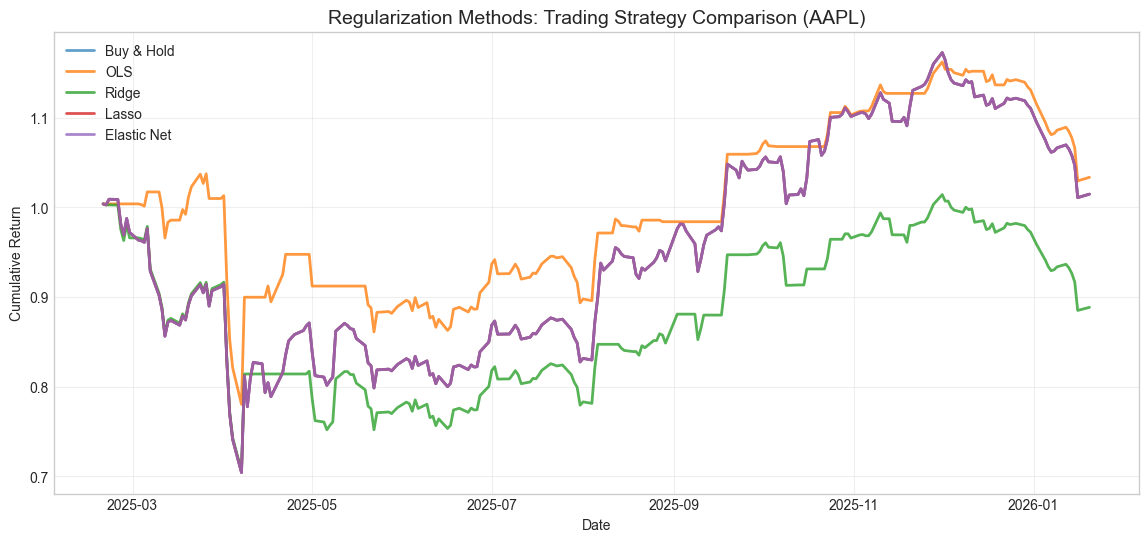

In [9]:
# Trading Strategy Backtest
backtest = pd.DataFrame(index=y_test.index)
backtest['actual'] = y_test.values

for name, model in models.items():
    pred = model.predict(X_test_scaled)
    backtest[f'{name}_signal'] = np.where(pred > 0, 1, 0)
    backtest[f'{name}_return'] = backtest[f'{name}_signal'] * backtest['actual']
    backtest[f'{name}_cum'] = (1 + backtest[f'{name}_return']).cumprod()

backtest['buy_hold_cum'] = (1 + backtest['actual']).cumprod()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(backtest.index, backtest['buy_hold_cum'], label='Buy & Hold', linewidth=2, alpha=0.7)
for name in models.keys():
    plt.plot(backtest.index, backtest[f'{name}_cum'], label=name, linewidth=2, alpha=0.8)
plt.title(f'Regularization Methods: Trading Strategy Comparison ({target_stock})', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [10]:
# Performance summary
def calc_sharpe(returns, rf=RISK_FREE_RATE):
    excess = returns.mean() * TRADING_DAYS - rf
    vol = returns.std() * np.sqrt(TRADING_DAYS)
    return excess / vol if vol > 0 else 0

def max_drawdown(cumulative):
    peak = cumulative.cummax()
    dd = (cumulative - peak) / peak
    return dd.min()

print("\n" + "="*80)
print("STRATEGY PERFORMANCE METRICS")
print("="*80)

print(f"\n{'Strategy':<15} {'Total Ret':>12} {'Sharpe':>10} {'Max DD':>10}")
print("-" * 50)
print(f"{'Buy & Hold':<15} {backtest['buy_hold_cum'].iloc[-1]-1:>12.2%} {calc_sharpe(backtest['actual']):>10.2f} {max_drawdown(backtest['buy_hold_cum']):>10.2%}")

for name in models.keys():
    ret = backtest[f'{name}_cum'].iloc[-1] - 1
    sharpe = calc_sharpe(backtest[f'{name}_return'])
    mdd = max_drawdown(backtest[f'{name}_cum'])
    print(f"{name:<15} {ret:>12.2%} {sharpe:>10.2f} {mdd:>10.2%}")


STRATEGY PERFORMANCE METRICS

Strategy           Total Ret     Sharpe     Max DD
--------------------------------------------------
Buy & Hold             1.48%       0.05    -30.22%
OLS                    3.35%       0.08    -24.80%
Ridge                -11.15%      -0.45    -29.68%
Lasso                  1.48%       0.05    -30.22%
Elastic Net            1.48%       0.05    -30.22%


In [11]:
# Next Day Prediction
latest_scaled = scaler.transform(X.iloc[[-1]])

print("\n" + "="*60)
print(f"📊 NEXT DAY PREDICTIONS FOR {target_stock}")
print("="*60)
print(f"\nDate: {df.index[-1].strftime('%Y-%m-%d')}")

for name, model in models.items():
    pred = model.predict(latest_scaled)[0]
    signal = '📈 LONG' if pred > 0 else '📉 STAY OUT'
    print(f"{name:<12}: {pred:>10.4%} → {signal}")

# Consensus
signals = [model.predict(latest_scaled)[0] > 0 for model in models.values()]
consensus = sum(signals) / len(signals)
print(f"\n🎯 Model Consensus: {consensus:.0%} bullish")


📊 NEXT DAY PREDICTIONS FOR AAPL

Date: 2026-01-20
OLS         :    0.6741% → 📈 LONG
Ridge       :    0.2296% → 📈 LONG
Lasso       :    0.0846% → 📈 LONG
Elastic Net :    0.0846% → 📈 LONG

🎯 Model Consensus: 100% bullish


---

## 🏢 Real-World Applications

| Company | Elastic Net Use Case |
|---------|---------------------|
| BlackRock | Multi-factor model estimation |
| Bridgewater | Risk parity factor selection |
| Two Sigma | High-dimensional signal extraction |
| D.E. Shaw | Cross-asset alpha modeling |

### Key Interview Points
1. **When Elastic Net?** - Groups of correlated features, p >> n
2. **L1 ratio selection?** - Start at 0.5, tune via CV
3. **Computational cost?** - Higher than Lasso/Ridge, but worth it for stability

---
## 📅 Tomorrow: Cross-Sectional Regression for Factor Modeling